In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
import scipy.stats as stats

## Load the data

In [2]:
df = pd.read_csv('revenue.csv')
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


## Data Cleaning

In [3]:
# check whether there is any na value
df.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [4]:
# check the uniqueness of user id
df['USER_ID'].nunique() == df['USER_ID'].shape[0]

False

In [5]:
# remove duplicated user id in both groups
duplicate_id = df.groupby('USER_ID')['VARIANT_NAME'].nunique() != 1
duplicate_id = duplicate_id[duplicate_id]

df = df[-df['USER_ID'].isin(duplicate_id.index)]
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
4,6174,variant,0.0
5,2380,variant,0.0
7,9168,control,0.0
9,7548,control,0.0


Text(0.5, 1.0, 'Before removing extreme values (outliers)')

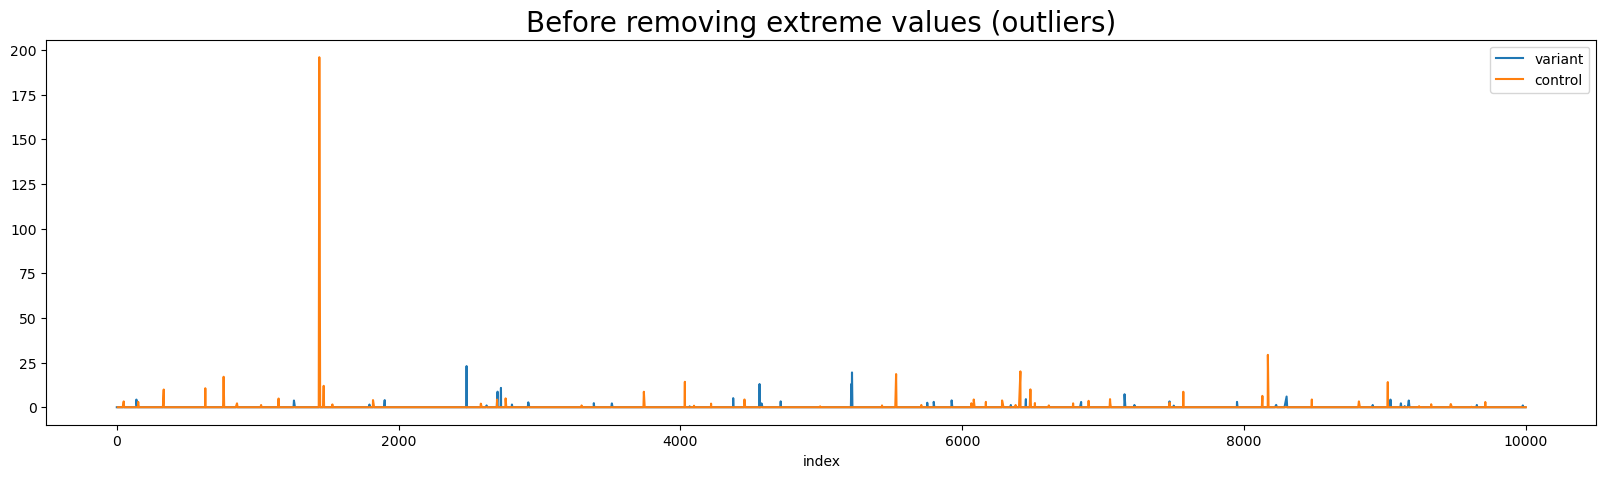

In [6]:
df_variant = df[df.VARIANT_NAME == 'variant']
df_control = df[df.VARIANT_NAME == 'control']

# check ouliers
df_variant.reset_index().set_index('index').REVENUE.plot(legend = True, label = 'variant', figsize = (20, 5))
df_control.reset_index().set_index('index').REVENUE.plot(legend = True, label = 'control', figsize = (20, 5))
plt.title('Before removing extreme values (outliers)', size = 20)

In [7]:
# define outlier thresholds/functions
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit.round(), up_limit.round()

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

Text(0.5, 1.0, 'After removing extreme values (outliers)')

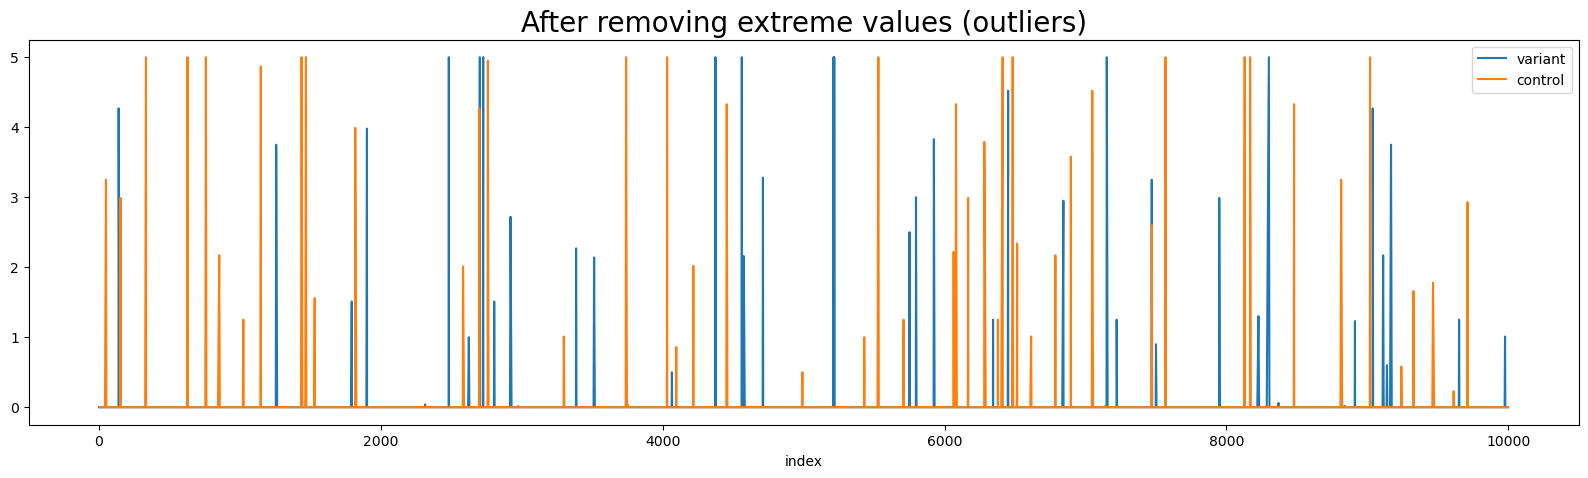

In [8]:
# remove the extreme value
replace_with_thresholds(df, 'REVENUE')
df_variant = df[df.VARIANT_NAME == 'variant']
df_control = df[df.VARIANT_NAME == 'control']

df_variant.reset_index().set_index('index').REVENUE.plot(legend = True, label = 'variant', figsize = (20, 5))
df_control.reset_index().set_index('index').REVENUE.plot(legend = True, label = 'control', figsize = (20, 5))
plt.title('After removing extreme values (outliers)', size = 20)

## Data Exploration

In [9]:
df.shape

(6070, 3)

In [10]:
df.describe()

,USER_ID,REVENUE
count,6070.000000,6070.000000
mean,4983.664086,0.046629
std,2897.990118,0.424273
min,2.000000,0.000000
25%,2472.250000,0.000000
50%,4950.000000,0.000000
75%,7501.000000,0.000000
max,9998.000000,5.000000


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6070 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       6070 non-null   int64  
 1   VARIANT_NAME  6070 non-null   object 
 2   REVENUE       6070 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 189.7+ KB


In [12]:
df.nunique()

USER_ID         4783
VARIANT_NAME       2
REVENUE           50
dtype: int64

In [13]:
# print unique values for treatment and control groups
df.VARIANT_NAME.unique()

array(['variant', 'control'], dtype=object)

Text(0.5, 1.0, 'Distribution for treatment group')

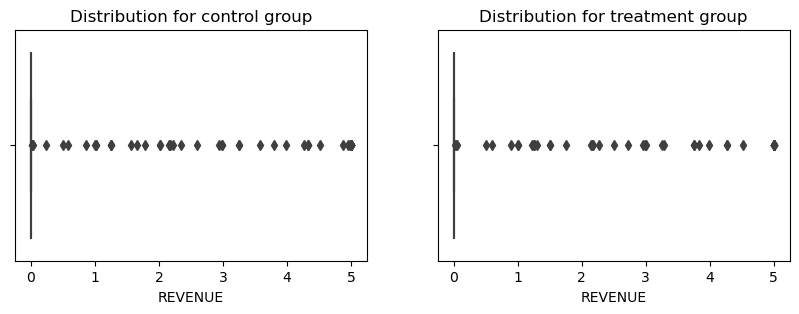

In [30]:
# check the distribution of control group and treatment group
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 3))
plt.subplot(1, 2, 1)
# df_control['REVENUE'].plot(ax = ax[0])
# sns.kdeplot(df_control['REVENUE'], fill = True)
sns.boxplot(x = df_control['REVENUE'])
plt.title('Distribution for control group')

plt.subplot(1, 2, 2)
# df_variant['REVENUE'].plot(ax = ax[1])
# sns.kdeplot(df_variant['REVENUE'], fill = True)
sns.boxplot(x = df_variant['REVENUE'])
plt.title('Distribution for treatment group')

In [15]:
# summary stats
df.groupby(['VARIANT_NAME']).REVENUE.agg(['count', 'median', 'mean', 'std', 'max']).reset_index()

,VARIANT_NAME,count,median,mean,std,max
0,control,3026,0.0,0.054547,0.465842,5.0
1,variant,3044,0.0,0.038758,0.378365,5.0


## A/B testing

In [16]:
# define A & B groups
df['VARIANT_NAME'] = np.where(df['VARIANT_NAME'] == 'control', 'A', 'B')
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,B,0.0
4,6174,B,0.0
5,2380,B,0.0
7,9168,A,0.0
9,7548,A,0.0


In [17]:
# define A/B testing function
def ABtesting(dataframe, group, target, standard):
    groupA = df[df[group] == 'A'][target]
    groupB = df[df[group] == 'B'][target]
    # check normal distribution 
    # True: Reject H0. Distribution is not normal.
    # False: Not reject H0. Distribution is normal.
    ntA = shapiro(groupA)[1] < standard
    ntB = shapiro(groupB)[1] < standard
    
    # check constant variance (True: Reject)
    # True: Reject H0. Not constant variance.
    # False: Not reject H0. Constant variance.
    leveneTest = stats.levene(groupA, groupB)[1] < standard
    
    if (ntA == False) & (ntB == False):
        if leveneTest == False:
            # normal & constant variance
            ttest = stats.ttest_ind(groupA, groupB, equal_var = True)[1]
        else:
            # normal & non-constant variance
            ttest = stats.ttest_ind(groupA, groupB, equal_var = False)[1]
    else:
        # non-parametric (non-normal)
        ttest = stats.mannwhitneyu(groupA, groupB)[1] 
    
    result = pd.DataFrame({'p-value':[ttest], 'test result' : [ttest < 0.05]})
    result['test type'] = np.where((ntA == False) & (ntB == False), 'Parametric', 'Non-parametric')
    result['test result'] = np.where(result['test result'] == False, 'Fail to reject H0.', 'Reject H0.')
    result['summary'] = np.where(result['test result'] == False, 'A/B groups are not similar.', 
                                 'A/B group are similar.')
    
    result = result[['test type', 'p-value', 'test result', 'summary']]
    return result

In [18]:
ABtesting(dataframe = df, group = 'VARIANT_NAME', target = 'REVENUE', standard = 0.05)

,test type,p-value,test result,summary
0,Non-parametric,0.244855,Fail to reject H0.,A/B group are similar.
